# Cement Production Type Identification 

## Overview

Cement production cycle comprises three main stages:

- Preparation of raw materials where limestone and silica-bearing minerals (clay, shale) are quarried and ground into a fine powder called raw meal
- Raw meal is heated in a kiln at temperatures as high as 1450 °C - chemical bonds of raw materials break down to produce clinker (calcined limestone): https://en.wikipedia.org/wiki/Cement_clinker - significant amounts of carbon dioxide (CO2) are released during this process
- Clinker is crushed and grounded into a fine powder in a cement mill and mixed with calcium sulphates (gypsum or anhydrite) to create cement: https://en.wikipedia.org/wiki/Cement_mill

Cement production is classified as either 'wet' or 'dry' - indicating moisture content of raw meal before it enters the kiln. In the wet process, water is added to the raw materials to form a raw thick slurry - the dry process relies on the preparation of  fine powdered raw meal with minimal water content. 

Responsible for approximately 5 percent of global carbon dioxide (CO2) emissions, global cement industry is moving towards more energy-efficient dry production methods - although optimal choice of the manufacturing process primarily depends on composition and moisture content of locally available raw materials. Wet process typically requires additional 50%-60% more heat energy in evaporation of wet slurry - however it is generally easier to control grinding and mixing of raw materials.

Cement kilns are the heart of cement manufactoring process - their size and number typically define the capacity of a cement plant. Accounting for more than 95% of world production, rotary kilns take the form of a long cylinder installed at an incline of 3–5° with ratio of length to diameter typically between 30:1 and 40:1. To achieve similar production rate, wet kiln systems are larger in size to accomodate additional dehydration zones to drive off moisture content from the kiln feed.

## Objective

This notebook reviews feasibility of building a computer vision model to automate reliable identification of plant production type from high resolution optical satellite imagery. To establish a baseline, preliminary analysis focussed on training a standard convolutional neural network (CNN) to classify image chips coincident with cement factory locations into wet and dry categories. Production type is a key indicator when assessing local and global environmental impact of cement plant operations. 

## Datasets

High resolution optical satellite imagery coincident with cement plant sites across the world was preprocessed into a collection of 256x256 pixel RGB JPEG files grouped into wet and dry sub-directories. To compute and evaluate model, categorised image chips were divided into training and test subsets according to 80-20 split - https://towardsdatascience.com/finally-why-we-use-an-80-20-split-for-training-and-test-data-plus-an-alternative-method-oh-yes-edc77e96295d. Subsequent cells manage download of this dataset from GCS bucket to local file system using Google Cloud SDK Python API.

To reduce its environmental impact and reduce cost, cement industry is moving towards more energy-efficient dry process technologies - hence dry mix plants greatly outnumber their wet process counterparts worldwide. As a consequence, an imbalance exists between sample sizes of dry and wet production types (approximately 9:1) - to ensure wet class is adequately represented during training, images of wet-process cement plants were randomly duplicated - see bar chart below.

In [1]:
import os

# authentication key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='C:/Users/Chris.Williams/.gcs/arkham-255409-c59a52d8653f.json'

In [2]:
from google.cloud import storage
from io import BytesIO

# download pretrained model from google cloud
client = storage.Client()
bucket = client.get_bucket('eo-ald-update')

# construct remote path
repo = 'ald'
filenames = [ 'models/vgg16-256-128.zip', 'data/chips.zip' ]

# check files exist
for f in filenames:

    pathname = os.path.join( os.getcwd(), f )
    if not os.path.exists( pathname ):
                
        # make sub-directory if required
        if not os.path.exists ( os.path.dirname( pathname ) ):
            os.makedirs( os.path.dirname( pathname ) )

        # download blob
        remote_url = '{}/cement/production-type/{}'.format( repo, f )

        blob = storage.blob.Blob( remote_url, bucket)
        with open( pathname, 'w+b' ) as z:
            blob.download_to_file( z )


In [3]:
from zipfile import ZipFile

# extract downloaded zip files 
for f in filenames:
    pathname = os.path.join( os.getcwd(), f )
#    with ZipFile( pathname, 'r') as zipObj:
       # extract contents to current directory
#       zipObj.extractall( os.path.dirname( pathname ) )

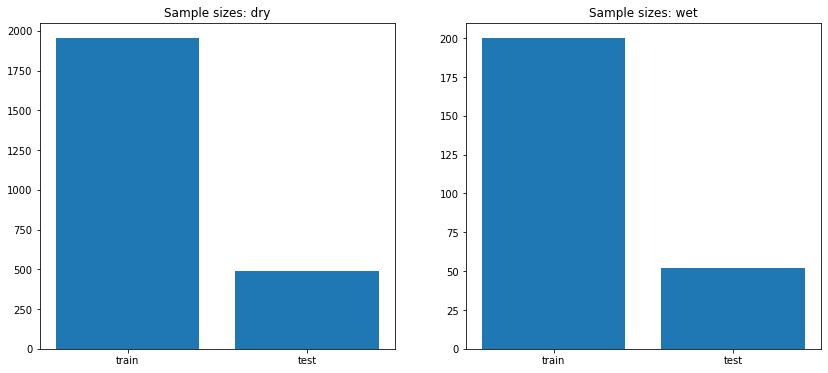

In [4]:
import matplotlib.pyplot as plt

# plot subset sample sizes for wet and dry classes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

classes = [ 'dry', 'wet' ]; 
for idx, c in enumerate( classes ):
    
    # get file list length - sample size
    count = [None] * 2
    for n, s in enumerate( [ 'train', 'test' ] ):
        path = os.path.join( 'data/chips/', s )
        count[ n ] = len( os.listdir( os.path.join( path, c ) ) )
                
    # draw counts as subplot
    axes[idx].set_title( 'Sample sizes: {}'.format ( c ) )
    axes[idx].bar( [ 'train', 'test' ], count )


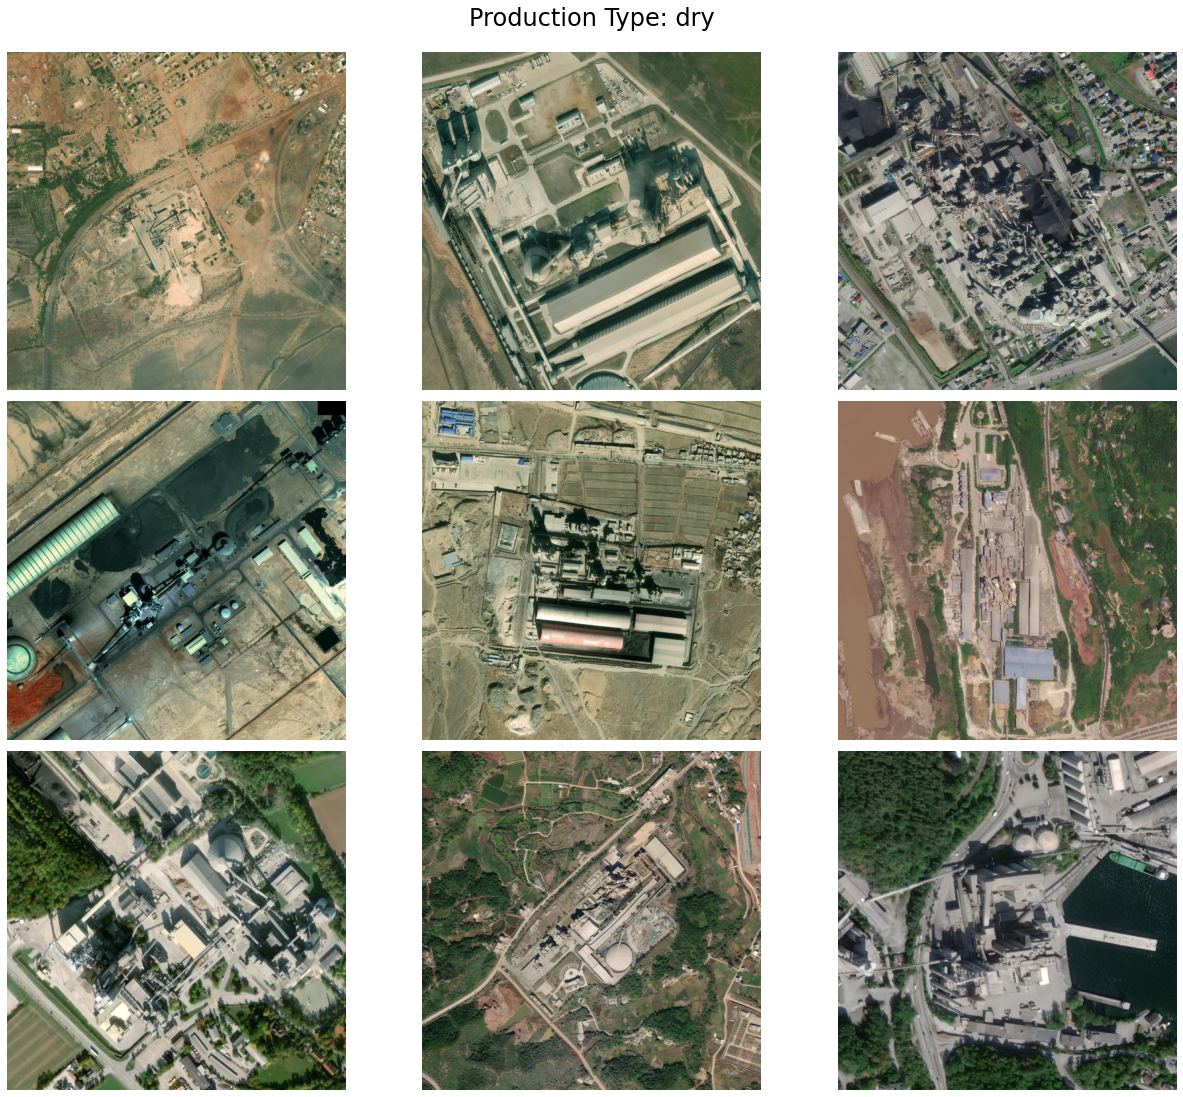

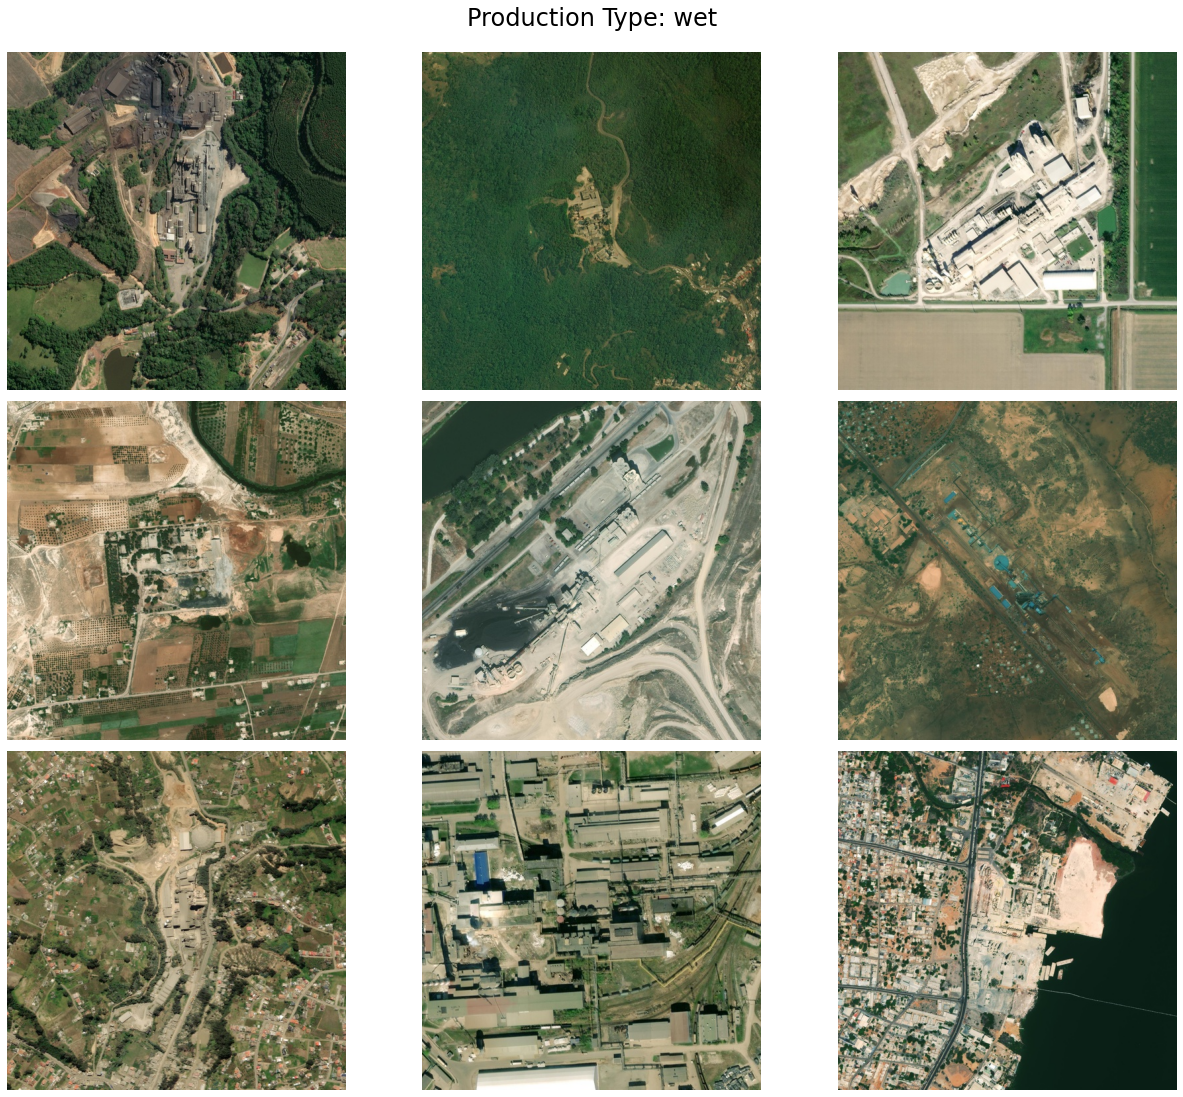

In [5]:
import random
from matplotlib.image import imread

# plot examples of wet and dry image chips 
classes = [ 'dry', 'wet' ]
for c in classes:
    
    fig = plt.figure( figsize=(18, 16) )    
    fig.suptitle('Production Type: {}'.format( c ), fontsize=24)
    
    # randomly select entries from file list
    files = os.listdir( os.path.join( 'data/chips/test', c ) )
    random.shuffle( files )
    for i in range(9):

        # define subplot
        plt.subplot( 330 + 1 + i )
        plt.axis('off')

        # load and show image
        image = imread( os.path.join( os.path.join( 'data/chips/test', c ), files[ i ] ) )
        plt.imshow(image)

    # tight layout with adjustment
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## Model Architecture and Training

A pretrained VGG16 CNN model was selected as backbone for this analysis - output from CNN model was flattened and attached to two fully connected layers comprising 256 and 128 units respectively and assigned tanh activation functions. The model was trained using an Adam optimiser - learning rate = 1e-6 - combined with binary cross-entropy loss function weighted for imbalance in class sample sizes - see: https://github.com/chris010970/satellite-image-ai/blob/master/projects/ald/cnn/cement/plant-type/src/train.py

Diagnostics captured during training indicated a steady reduction in training loss and increase in precision and recall (> 0.95) over 2000 epochs - small adjustments were applied to Adam learning rate to refine model fit.

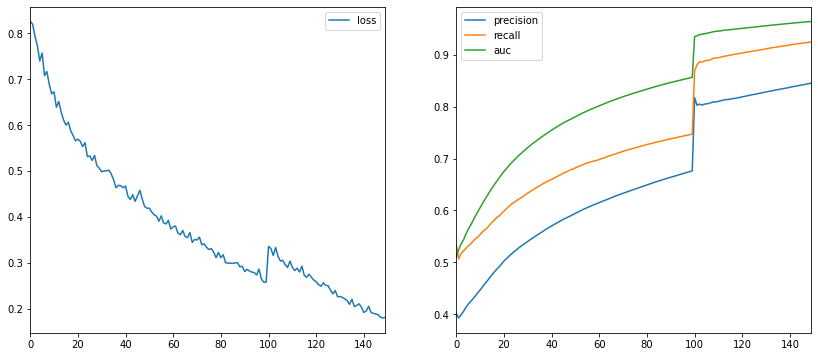

In [6]:
import pandas as pd

# plot diagnostics of model downloaded from GCS
df=pd.read_csv( os.path.join( os.getcwd(), 'models\\vgg16-256-128\\log.csv') )
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
df.plot.line( ax=axes[0], y=['loss'])
df.plot.line( ax=axes[1], y=['precision','recall','auc'])


## Results

Quality of binary classification model was assessed by computing confusion matrices against train and test subsets. As indicated in plots below, custom-built VGG16 CNN model converged to a fit delivering close to 100% accuracy on the training dataset. However test results indicated strong evidence of model overfitting where majority of samples (67%) in wet production category were wrongly classified as dry production plants. 

These results provide a benchmark for further improvement - there are a number of potential avenues to explore for enhancing generalisation including assessment of hybrid models - architectures combining CNNs trained with imagery captured at different spatial resolutions - also MLP networks trained with socioeconomic / environment indicators specific to each site - for example, GDP, average monthly temperature, etc.


In [7]:
import tensorflow as tf

# initiate tensorflow session - allow access to all onboard CPU / GPU resources
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\program files\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [8]:
from utility.dl.cnn import loadFromFile

# load pre-trained model from file - downloaded from GCS
model, model_type = loadFromFile( 'models/vgg16-256-128' )


Using TensorFlow backend.


Loaded model from disk: models/vgg16-256-128


In [9]:
import importlib
from keras.preprocessing.image import ImageDataGenerator

# select preprocess_input wrapper
module = importlib.import_module( 'keras.applications.{}'.format( model_type ) )
preprocess_input = module.preprocess_input
        
# create test generator
datagen = ImageDataGenerator( preprocessing_function=preprocess_input )


In [10]:
def getPrediction( path, model, datagen ):
    
    # get test iterator - binary classification
    it = datagen.flow_from_directory( path,
                                    class_mode=None, 
                                    color_mode='rgb',
                                    shuffle=False,
                                    batch_size=1, 
                                    target_size=(256,256) )
    
    # run prediction and threshold probabilities
    probabilities = model.predict_generator( it )
    return it, probabilities > 0.5


In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def getConfusionMatrix( it, y_pred ):
    
    # compute normalised confusion matrix 
    cm = confusion_matrix( it.classes, y_pred )
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    classes = list( it.class_indices.keys() )
    return pd.DataFrame( cm, index=classes, columns=classes )


In [12]:
import seaborn as sn

def plotConfusionMatrix( df ):
    
    # plot dataframe as annotated heatmap
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('Normalised Confusion Matrix (Production Type)')

    sn.set(font_scale=1.1) # for label size
    sn.heatmap(df, annot=True, annot_kws={"size": 16}, fmt='.2f' ) # font size

    plt.show()
    return


In [13]:
def getWronguns( it, y_pred ):
    
    # get pathnames of incorrectly classified images
    wronguns = { 'dry': [], 'wet' : [] }
    for idx, label in enumerate( it.class_indices.keys() ):
        items = np.argwhere( (it.classes==idx) & (y_pred.flatten()==1-idx) ).flatten()
        wronguns[ label ] = [ it.filepaths[i] for i in items ]

    return wronguns


In [14]:
def plotWronguns( wronguns ):
    
    # plot examples of wet and dry image chips 
    classes = [ 'dry', 'wet' ]
    for c in classes:
        
        num_images = min( 15, len( wronguns[ c ] ) )
        if num_images > 0:

            # get rows and columns
            columns = 5; rows = num_images / columns + 1    

            fig = plt.figure( figsize=(18, ( rows * 3 ) ) )
            fig.suptitle('Misclassfied Images: {}'.format( c ), fontsize=24)

            # display thumbnails of misclassified images
            for idx, pathname in enumerate( wronguns[ c ] ):

                image = imread( pathname )
                ax = plt.subplot( rows, columns, idx + 1 )
                ax.set_title( os.path.basename( pathname ) )

                plt.axis('off')            
                plt.imshow(image)
                
                if idx == num_images:
                    break

            # tight layout with adjustment
            fig.tight_layout(rect=[0, 0.05, 1, 0.95])    
            plt.show()
        
    return


Found 2154 images belonging to 2 classes.



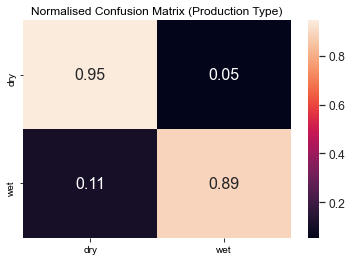

In [15]:
# get prediction
it, y_pred = getPrediction( os.path.join( os.getcwd(), 'data/chips/train' ), model, datagen )

# compute and plot confusion matrix
cm = getConfusionMatrix( it, y_pred )
plotConfusionMatrix( cm )

In [16]:
# identify and plot misclassified images
wronguns = getWronguns( it, y_pred )
# plotWronguns( wronguns )

Found 542 images belonging to 2 classes.


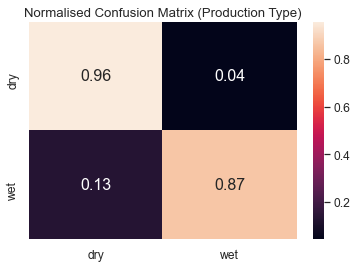

In [17]:
# get prediction
it, y_pred = getPrediction( os.path.join( os.getcwd(), 'data/chips/test' ), model, datagen )

# compute and plot confusion matrix
cm = getConfusionMatrix( it, y_pred )
plotConfusionMatrix( cm )

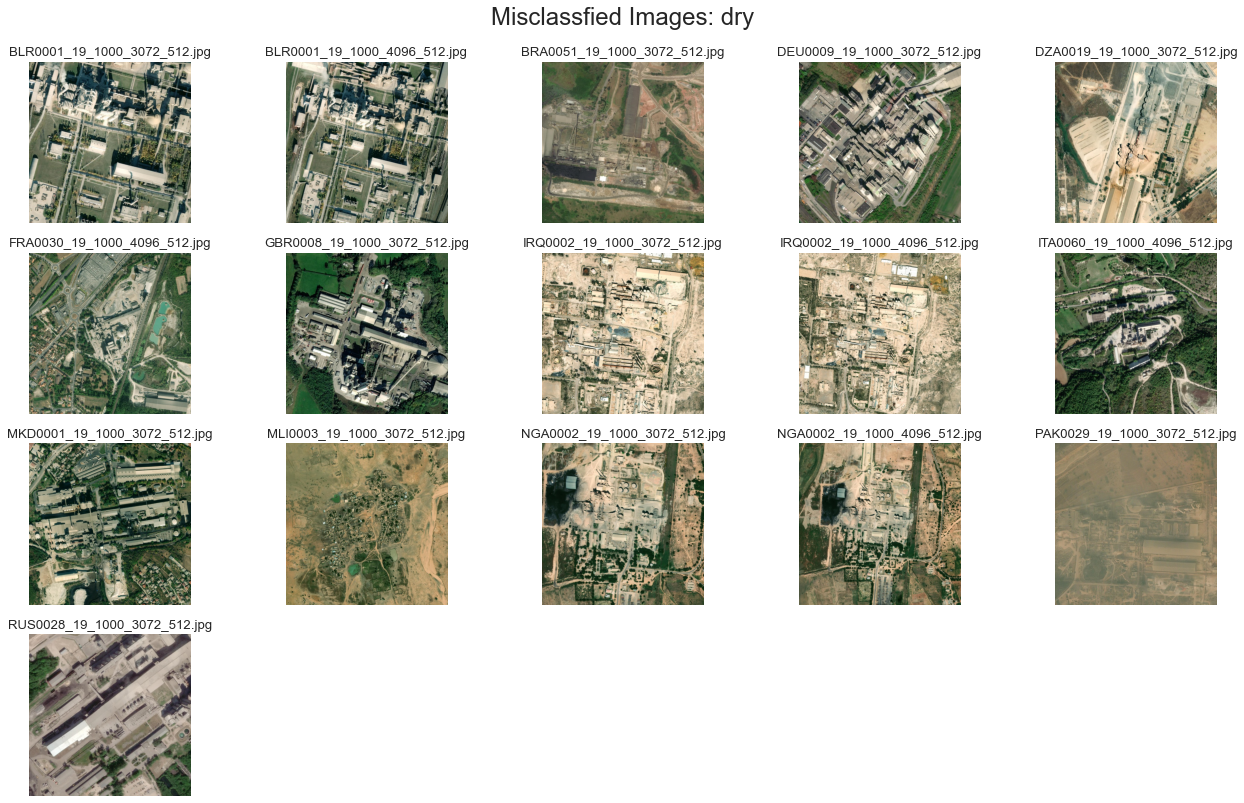

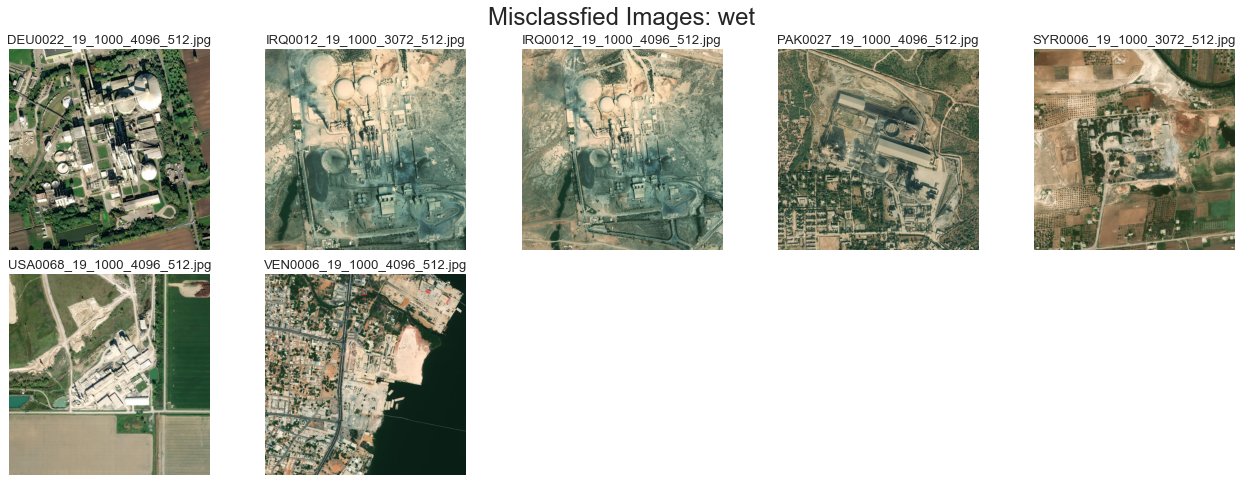

In [18]:
# identify and plot misclassified images
wronguns = getWronguns( it, y_pred )
plotWronguns( wronguns )

Analysis subsequently focussed on predicting ‘wet’ or ‘dry’ classification for cement factories whose production type is currently unspecified in OSS data tables – 914 factories with ‘exact’ location accuracy. Output value of custom VGG16 model is a continuous sigmoid value between zero and one – represents confidence in predicted classification. Model output values > 0.9 or < 0.1 assumed to indicate high confidence predictions – otherwise low confidence.

In [19]:
# finally run model against unlabelled images - unknown production type
path = os.path.join( os.getcwd(), 'data/chips/unlabelled' )
it = datagen.flow_from_directory( path, 
                                classes=['test'], 
                                color_mode='rgb',
                                shuffle=False,
                                batch_size=1, 
                                target_size=(256,256) )

# evaluate probabilities
y_pred = model.predict_generator( it )

Found 914 images belonging to 1 classes.


In [20]:
# compile results
records = []
for idx, filename in enumerate ( it.filenames ):

    # assign label and confidence
    label = 'wet' if y_pred[ idx ] > 0.5 else 'dry'
    confidence = 'high' if y_pred[ idx ] > 0.9 or y_pred[ idx ] < 0.1 else 'low'

    records.append (  { 'filename':  os.path.basename( filename ),
                        'label' : label,
                        'probability' : y_pred[ idx ],
                        'confidence' : confidence } )

# convert to dataframe
df = pd.DataFrame.from_dict( records )
df = df.sort_values( 'label' )

In [21]:
print ( 'Total number of unseen images: {}'.format( len( it.filenames ) ) )
print ( 'High confidence dry predictions: {}'.format( len(  df [ ( df['confidence']=='high' ) & ( df[ 'label']=='dry' ) ] ) ) )
print ( 'High confidence wet predictions: {}'.format( len(  df [ ( df['confidence']=='high' ) & ( df[ 'label']=='wet' ) ] ) ) )

Total number of unseen images: 914
High confidence dry predictions: 564
High confidence wet predictions: 33


In [22]:
df

filename label     probability confidence
0    AGO0001_19_1000_4096_512.jpg   dry    [0.09019779]       high
570  ITA0014_19_1000_4096_512.jpg   dry   [0.032722842]       high
571  ITA0015_19_1000_4096_512.jpg   dry    [0.38590774]        low
572  ITA0016_19_1000_4096_512.jpg   dry     [0.4319908]        low
574  ITA0019_19_1000_4096_512.jpg   dry  [0.0036520737]       high
..                            ...   ...             ...        ...
89   BRA0017_19_1000_4096_512.jpg   wet     [0.6961693]        low
280  FRA0020_19_1000_4096_512.jpg   wet     [0.6528927]        low
84   BRA0003_19_1000_4096_512.jpg   wet     [0.9658643]       high
587  ITA0044_19_1000_4096_512.jpg   wet     [0.5560915]        low
200  CMR0003_19_1000_4096_512.jpg   wet    [0.81537807]        low

[914 rows x 4 columns]

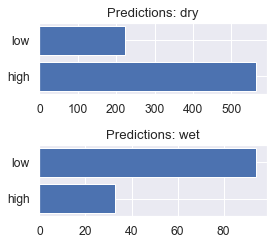

In [23]:
# create figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 4))
for idx, s in enumerate( [ 'dry', 'wet' ] ):

    df_subset = df [ ( df[ 'label'] == s ) ]
    count = [ len ( df_subset [ ( df_subset ['confidence'] == 'high' ) ] ), len ( df_subset [ ( df_subset ['confidence'] == 'low' ) ] ) ]
    
    axes[ idx ].barh( [ 'high', 'low' ], count )
    axes[ idx ].set_title( 'Predictions: {}'.format( s ) )

# show figure
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()